# Research Question 8: Sentiment as Leading Indicator

**Question**: How effectively does a downturn in average tweet sentiment forecast a rise in confirmed cases one or two weeks later?

**Datasets**: COVID-19 Tweets (Dataset 1) & JHU CSSE COVID-19 Cases (Dataset 4)

**Approach**: 
1. Identify significant downturns in daily average sentiment
2. Track COVID-19 case increases 7-14 days after sentiment downturns
3. Calculate predictive accuracy and lead-lag correlations
4. Assess the effectiveness of sentiment as an early warning indicator

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")
print("Analysis: Sentiment as Leading Indicator for Case Surges")

Libraries loaded successfully!
Analysis: Sentiment as Leading Indicator for Case Surges


## Data Loading and Preparation

In [22]:
# Load datasets
try:
    # Load processed tweet data
    tweets_df = pd.read_csv('../data/processed/tweets_with_nlp_features.csv')
    daily_tweets = pd.read_csv('../data/processed/daily_tweet_sentiment_topics.csv')
    
    # Load JHU COVID cases data
    cases_df = pd.read_csv('../data/raw/jhu_csse/time_series_covid19_confirmed_global.csv')
    
    print(f"Tweet data loaded: {tweets_df.shape}")
    print(f"Daily aggregated tweets: {daily_tweets.shape}")
    print(f"JHU cases data: {cases_df.shape}")
    
    # Convert date columns
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    daily_tweets['date_only'] = pd.to_datetime(daily_tweets['date_only'])
    
    print("\nData loaded and dates converted successfully!")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure all required data files exist.")

Tweet data loaded: (162827, 28)
Daily aggregated tweets: (26, 12)
JHU cases data: (289, 1147)

Data loaded and dates converted successfully!


In [23]:
# Process and prepare global COVID cases data
print("Processing COVID cases data...")

# Melt the cases dataframe to long format
cases_melted = cases_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
    var_name='date_str',
    value_name='cumulative_cases'
)

# Convert date format and filter for analysis period
cases_melted['date'] = pd.to_datetime(cases_melted['date_str'])

# Focus on major countries and global trend
major_countries = ['US', 'United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Canada', 'Australia', 'India', 'Brazil']

# Get global daily cases
global_cases = cases_melted.groupby(['Country/Region', 'date'])['cumulative_cases'].sum().reset_index()

# Calculate daily new cases
global_cases = global_cases.sort_values(['Country/Region', 'date'])
global_cases['daily_new_cases'] = global_cases.groupby('Country/Region')['cumulative_cases'].diff()
global_cases['daily_new_cases'] = global_cases['daily_new_cases'].fillna(0)
global_cases['daily_new_cases'] = np.maximum(global_cases['daily_new_cases'], 0)  # Remove negative values

# Focus on major countries for better signal
major_country_cases = global_cases[global_cases['Country/Region'].isin(major_countries)]

# Calculate 7-day rolling average to smooth data
major_country_cases['cases_7day_avg'] = major_country_cases.groupby('Country/Region')['daily_new_cases'].rolling(window=7, center=True).mean().reset_index(level=0, drop=True)

# Aggregate to global trend
global_daily_cases = major_country_cases.groupby('date').agg({
    'daily_new_cases': 'sum',
    'cases_7day_avg': 'sum'
}).reset_index()

# Calculate case growth rates
global_daily_cases['cases_growth_rate'] = global_daily_cases['cases_7day_avg'].pct_change(periods=7)
global_daily_cases['cases_growth_rate'] = global_daily_cases['cases_growth_rate'].fillna(0)

# Focus on tweet analysis period (July-August 2020) and extend forward for prediction assessment
tweet_start = pd.to_datetime('2020-07-24')
analysis_end = pd.to_datetime('2020-09-15')  # Extended to assess 2-week predictions

analysis_cases = global_daily_cases[
    (global_daily_cases['date'] >= tweet_start) & 
    (global_daily_cases['date'] <= analysis_end)
].copy()

print(f"Cases data processed for period: {analysis_cases['date'].min()} to {analysis_cases['date'].max()}")
print(f"Average daily cases: {analysis_cases['daily_new_cases'].mean():.0f}")
print(f"Average 7-day cases: {analysis_cases['cases_7day_avg'].mean():.0f}")

Processing COVID cases data...
Cases data processed for period: 2020-07-24 00:00:00 to 2020-09-15 00:00:00
Average daily cases: 170113
Average 7-day cases: 170712
Cases data processed for period: 2020-07-24 00:00:00 to 2020-09-15 00:00:00
Average daily cases: 170113
Average 7-day cases: 170712


In [24]:
# Prepare sentiment data for analysis
print("Preparing sentiment data...")

# Ensure we have the daily sentiment data
daily_sentiment = daily_tweets.copy()

# Calculate rolling averages and identify sentiment downturns
daily_sentiment['sentiment_3day_avg'] = daily_sentiment['vader_compound'].rolling(window=3, center=True).mean()
daily_sentiment['sentiment_7day_avg'] = daily_sentiment['vader_compound'].rolling(window=7, center=True).mean()

# Calculate sentiment change rates
daily_sentiment['sentiment_change_1day'] = daily_sentiment['vader_compound'].diff()
daily_sentiment['sentiment_change_3day'] = daily_sentiment['sentiment_3day_avg'].diff(periods=3)
daily_sentiment['sentiment_change_7day'] = daily_sentiment['sentiment_7day_avg'].diff(periods=7)

# Define sentiment downturn criteria
# A significant downturn is defined as:
# 1. Drop of more than 1 standard deviation from recent average
# 2. Or drop below certain percentile threshold

sentiment_std = daily_sentiment['vader_compound'].std()
sentiment_mean = daily_sentiment['vader_compound'].mean()
downturn_threshold = sentiment_mean - (0.5 * sentiment_std)  # 0.5 std below mean

# Identify significant downturns
daily_sentiment['is_sentiment_downturn'] = (
    (daily_sentiment['vader_compound'] < downturn_threshold) &
    (daily_sentiment['sentiment_change_3day'] < -0.01)  # Additional condition: recent decline
)

# Calculate percentile-based indicators
daily_sentiment['sentiment_percentile'] = daily_sentiment['vader_compound'].rank(pct=True)
daily_sentiment['is_low_sentiment'] = daily_sentiment['sentiment_percentile'] < 0.25  # Bottom quartile

print(f"Sentiment analysis period: {daily_sentiment['date_only'].min()} to {daily_sentiment['date_only'].max()}")
print(f"Average sentiment: {daily_sentiment['vader_compound'].mean():.4f}")
print(f"Sentiment std deviation: {sentiment_std:.4f}")
print(f"Downturn threshold: {downturn_threshold:.4f}")
print(f"Days with significant downturns: {daily_sentiment['is_sentiment_downturn'].sum()}")
print(f"Days in bottom quartile: {daily_sentiment['is_low_sentiment'].sum()}")

Preparing sentiment data...
Sentiment analysis period: 2020-07-24 00:00:00 to 2020-08-30 00:00:00
Average sentiment: 0.0583
Sentiment std deviation: 0.0228
Downturn threshold: 0.0469
Days with significant downturns: 4
Days in bottom quartile: 6


## Leading Indicator Analysis

In [25]:
# Merge sentiment and cases data for lead-lag analysis
print("Analyzing sentiment as leading indicator...")

# Create merged dataset
merged_data = pd.merge(
    daily_sentiment[['date_only', 'vader_compound', 'sentiment_3day_avg', 'is_sentiment_downturn', 'is_low_sentiment']],
    analysis_cases[['date', 'daily_new_cases', 'cases_7day_avg', 'cases_growth_rate']],
    left_on='date_only', right_on='date', how='inner'
)

merged_data = merged_data.sort_values('date_only')

print(f"Merged dataset: {len(merged_data)} days")

# Define case surge criteria
cases_mean = merged_data['cases_7day_avg'].mean()
cases_std = merged_data['cases_7day_avg'].std()
surge_threshold = cases_mean + (0.5 * cases_std)  # 0.5 std above mean

# Identify case surges
merged_data['is_case_surge'] = merged_data['cases_7day_avg'] > surge_threshold
merged_data['is_growth_acceleration'] = merged_data['cases_growth_rate'] > 0.1  # >10% weekly growth

print(f"Case surge threshold (7-day avg): {surge_threshold:.0f}")
print(f"Days with case surges: {merged_data['is_case_surge'].sum()}")
print(f"Days with growth acceleration: {merged_data['is_growth_acceleration'].sum()}")

# Create prediction dataset with lead times
prediction_results = []

for lead_days in [7, 10, 14]:  # 1, 1.5, and 2 weeks
    print(f"\nAnalyzing {lead_days}-day lead predictions...")
    
    # Shift case surge indicators backward by lead_days to test prediction
    merged_data[f'case_surge_{lead_days}d_later'] = merged_data['is_case_surge'].shift(-lead_days)
    merged_data[f'growth_accel_{lead_days}d_later'] = merged_data['is_growth_acceleration'].shift(-lead_days)
    
    # Remove rows where we don't have future case data
    valid_data = merged_data.dropna(subset=[f'case_surge_{lead_days}d_later', f'growth_accel_{lead_days}d_later'])
    
    if len(valid_data) == 0:
        print(f"  No valid data for {lead_days}-day predictions")
        continue
    
    # Calculate prediction accuracy for case surges
    true_positives = ((valid_data['is_sentiment_downturn']) & (valid_data[f'case_surge_{lead_days}d_later'])).sum()
    false_positives = ((valid_data['is_sentiment_downturn']) & (~valid_data[f'case_surge_{lead_days}d_later'])).sum()
    true_negatives = ((~valid_data['is_sentiment_downturn']) & (~valid_data[f'case_surge_{lead_days}d_later'])).sum()
    false_negatives = ((~valid_data['is_sentiment_downturn']) & (valid_data[f'case_surge_{lead_days}d_later'])).sum()
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(valid_data)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate correlation
    correlation = valid_data['vader_compound'].corr(valid_data[f'case_surge_{lead_days}d_later'].astype(int))
    
    prediction_results.append({
        'lead_days': lead_days,
        'total_observations': len(valid_data),
        'sentiment_downturns': valid_data['is_sentiment_downturn'].sum(),
        'case_surges': valid_data[f'case_surge_{lead_days}d_later'].sum(),
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'correlation': correlation
    })
    
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  F1-Score: {f1_score:.3f}")
    print(f"  Correlation: {correlation:.3f}")

# Convert to DataFrame
prediction_df = pd.DataFrame(prediction_results)
print("\nPrediction analysis completed!")

Analyzing sentiment as leading indicator...
Merged dataset: 26 days
Case surge threshold (7-day avg): 169294
Days with case surges: 7
Days with growth acceleration: 6

Analyzing 7-day lead predictions...
  Precision: 0.333
  Recall: 0.143
  Accuracy: 0.947
  F1-Score: 0.200
  Correlation: 0.085

Analyzing 10-day lead predictions...
  Precision: 0.333
  Recall: 0.143
  Accuracy: 0.938
  F1-Score: 0.200
  Correlation: -0.135

Analyzing 14-day lead predictions...
  Precision: 0.000
  Recall: 0.000
  Accuracy: 0.917
  F1-Score: 0.000
  Correlation: 0.101

Prediction analysis completed!


In [26]:
# Cross-correlation analysis to find optimal lead time
print("Performing cross-correlation analysis...")

# Prepare time series for cross-correlation
sentiment_series = merged_data['vader_compound'].values
cases_series = merged_data['cases_7day_avg'].values

# Calculate cross-correlations at different lags
max_lag = 21
correlations = []
lags = range(0, max_lag + 1)

for lag in lags:
    if lag == 0:
        corr = np.corrcoef(sentiment_series, cases_series)[0, 1]
    else:
        # Sentiment leads cases by 'lag' days
        if len(sentiment_series) > lag:
            corr = np.corrcoef(sentiment_series[:-lag], cases_series[lag:])[0, 1]
        else:
            corr = 0
    
    correlations.append(corr)

# Find optimal lag (most negative correlation, since low sentiment should predict high cases)
optimal_lag_idx = np.argmin(correlations)  # Most negative correlation
optimal_lag = lags[optimal_lag_idx]
optimal_correlation = correlations[optimal_lag_idx]

print(f"Optimal lag: {optimal_lag} days")
print(f"Optimal correlation: {optimal_correlation:.4f}")

# Statistical significance test for optimal lag
n = len(sentiment_series) - optimal_lag if optimal_lag > 0 else len(sentiment_series)
if optimal_lag == 0:
    _, p_value = stats.pearsonr(sentiment_series, cases_series)
else:
    _, p_value = stats.pearsonr(sentiment_series[:-optimal_lag], cases_series[optimal_lag:])

print(f"P-value for optimal correlation: {p_value:.6f}")
print(f"Statistically significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Store correlation results
correlation_results = pd.DataFrame({
    'lag_days': lags,
    'correlation': correlations
})

Performing cross-correlation analysis...
Optimal lag: 11 days
Optimal correlation: -0.3855
P-value for optimal correlation: 0.155854
Statistically significant at α=0.05: No


## Visualizations

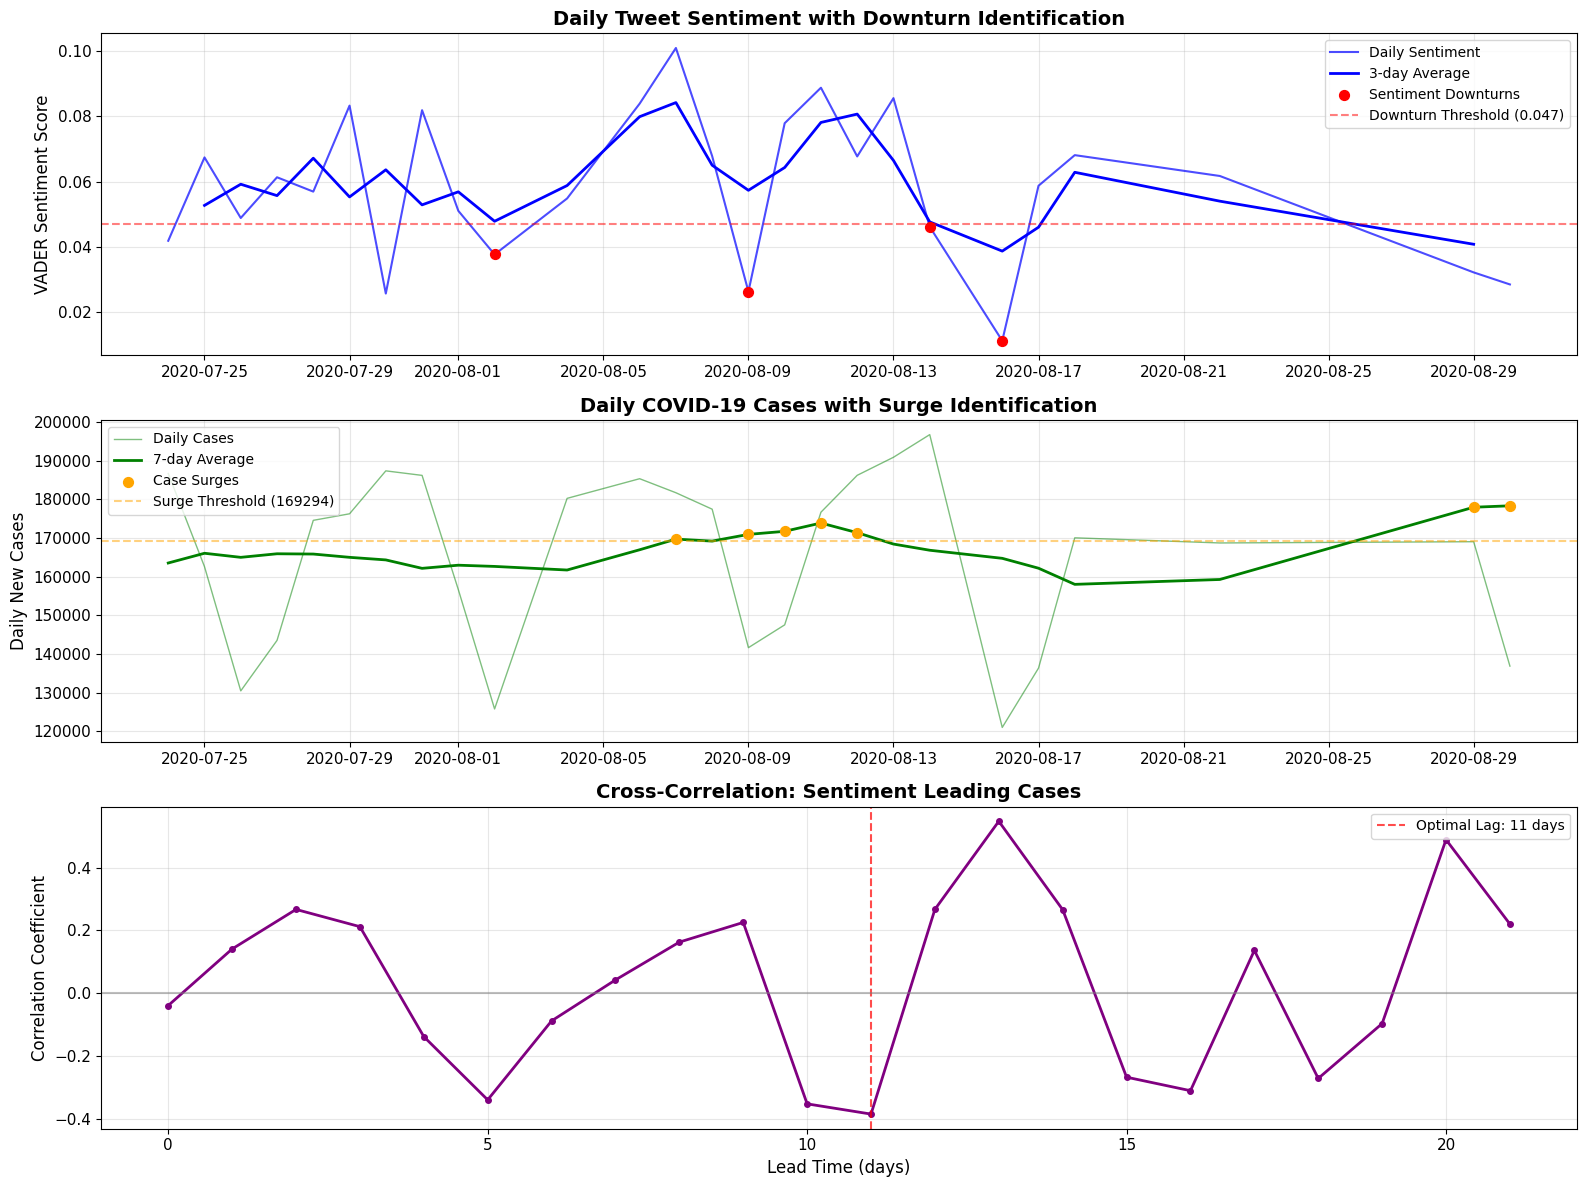

Timeline visualization completed showing sentiment-case relationship.


In [27]:
# Timeline visualization showing sentiment and cases
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Daily sentiment with downturns highlighted
ax1.plot(merged_data['date_only'], merged_data['vader_compound'], 'b-', linewidth=1.5, alpha=0.7, label='Daily Sentiment')
ax1.plot(merged_data['date_only'], merged_data['sentiment_3day_avg'], 'b-', linewidth=2, label='3-day Average')

# Highlight sentiment downturns
downturn_dates = merged_data[merged_data['is_sentiment_downturn']]['date_only']
downturn_values = merged_data[merged_data['is_sentiment_downturn']]['vader_compound']
ax1.scatter(downturn_dates, downturn_values, color='red', s=50, zorder=5, label='Sentiment Downturns')

ax1.axhline(y=downturn_threshold, color='red', linestyle='--', alpha=0.5, label=f'Downturn Threshold ({downturn_threshold:.3f})')
ax1.set_title('Daily Tweet Sentiment with Downturn Identification', fontsize=14, fontweight='bold')
ax1.set_ylabel('VADER Sentiment Score', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Case trends with surges highlighted
ax2.plot(merged_data['date_only'], merged_data['daily_new_cases'], 'g-', linewidth=1, alpha=0.5, label='Daily Cases')
ax2.plot(merged_data['date_only'], merged_data['cases_7day_avg'], 'g-', linewidth=2, label='7-day Average')

# Highlight case surges
surge_dates = merged_data[merged_data['is_case_surge']]['date_only']
surge_values = merged_data[merged_data['is_case_surge']]['cases_7day_avg']
ax2.scatter(surge_dates, surge_values, color='orange', s=50, zorder=5, label='Case Surges')

ax2.axhline(y=surge_threshold, color='orange', linestyle='--', alpha=0.5, label=f'Surge Threshold ({surge_threshold:.0f})')
ax2.set_title('Daily COVID-19 Cases with Surge Identification', fontsize=14, fontweight='bold')
ax2.set_ylabel('Daily New Cases', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Cross-correlation at different lags
ax3.plot(correlation_results['lag_days'], correlation_results['correlation'], 'purple', linewidth=2, marker='o', markersize=4)
ax3.axvline(x=optimal_lag, color='red', linestyle='--', alpha=0.7, label=f'Optimal Lag: {optimal_lag} days')
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_title('Cross-Correlation: Sentiment Leading Cases', fontsize=14, fontweight='bold')
ax3.set_xlabel('Lead Time (days)', fontsize=12)
ax3.set_ylabel('Correlation Coefficient', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Timeline visualization completed showing sentiment-case relationship.")

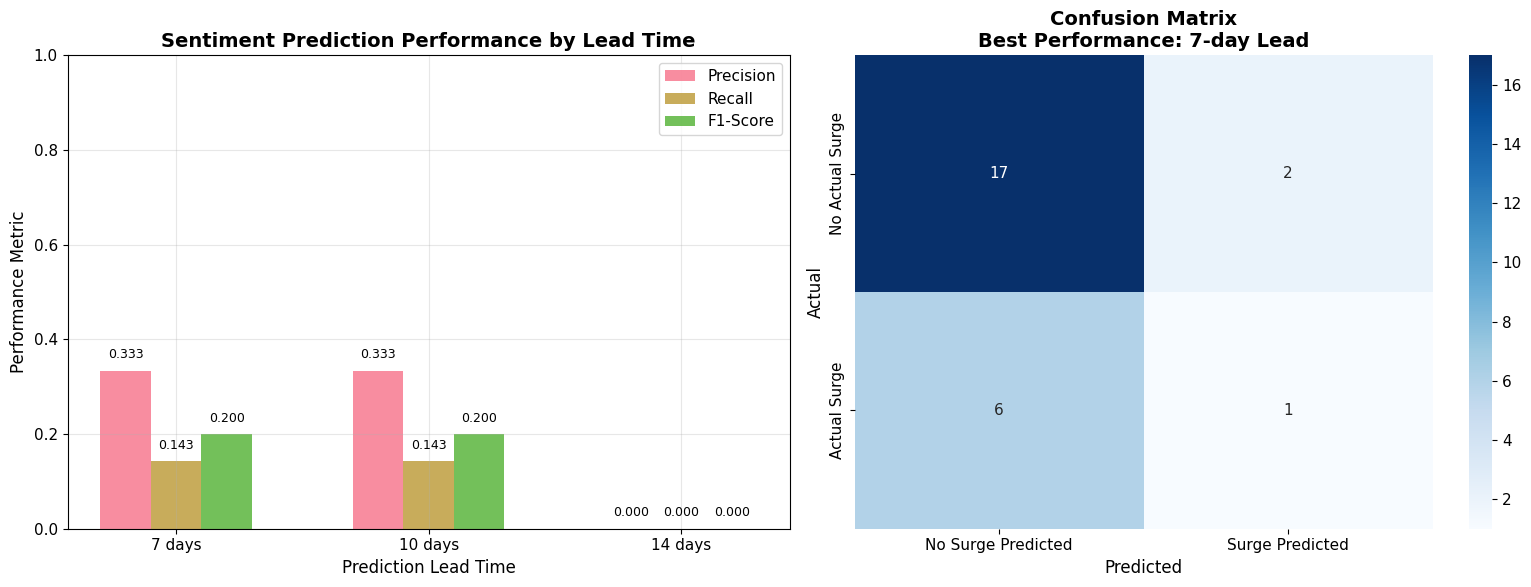

Prediction performance visualization completed. Best lead time: 7 days


In [28]:
# Prediction performance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediction metrics by lead time
x_pos = np.arange(len(prediction_df))
width = 0.2

ax1.bar(x_pos - width, prediction_df['precision'], width, label='Precision', alpha=0.8)
ax1.bar(x_pos, prediction_df['recall'], width, label='Recall', alpha=0.8)
ax1.bar(x_pos + width, prediction_df['f1_score'], width, label='F1-Score', alpha=0.8)

ax1.set_xlabel('Prediction Lead Time', fontsize=12)
ax1.set_ylabel('Performance Metric', fontsize=12)
ax1.set_title('Sentiment Prediction Performance by Lead Time', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{days} days' for days in prediction_df['lead_days']])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels on bars
for i, (precision, recall, f1) in enumerate(zip(prediction_df['precision'], prediction_df['recall'], prediction_df['f1_score'])):
    ax1.text(i - width, precision + 0.02, f'{precision:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i, recall + 0.02, f'{recall:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Confusion matrix for best-performing lead time
best_performance_idx = prediction_df['f1_score'].idxmax()
best_lead_time = prediction_df.loc[best_performance_idx, 'lead_days']

# Create confusion matrix data
conf_matrix = np.array([
    [prediction_df.loc[best_performance_idx, 'true_negatives'], prediction_df.loc[best_performance_idx, 'false_positives']],
    [prediction_df.loc[best_performance_idx, 'false_negatives'], prediction_df.loc[best_performance_idx, 'true_positives']]
])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Surge Predicted', 'Surge Predicted'],
           yticklabels=['No Actual Surge', 'Actual Surge'], ax=ax2)

ax2.set_title(f'Confusion Matrix\nBest Performance: {best_lead_time}-day Lead', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Prediction performance visualization completed. Best lead time: {best_lead_time} days")

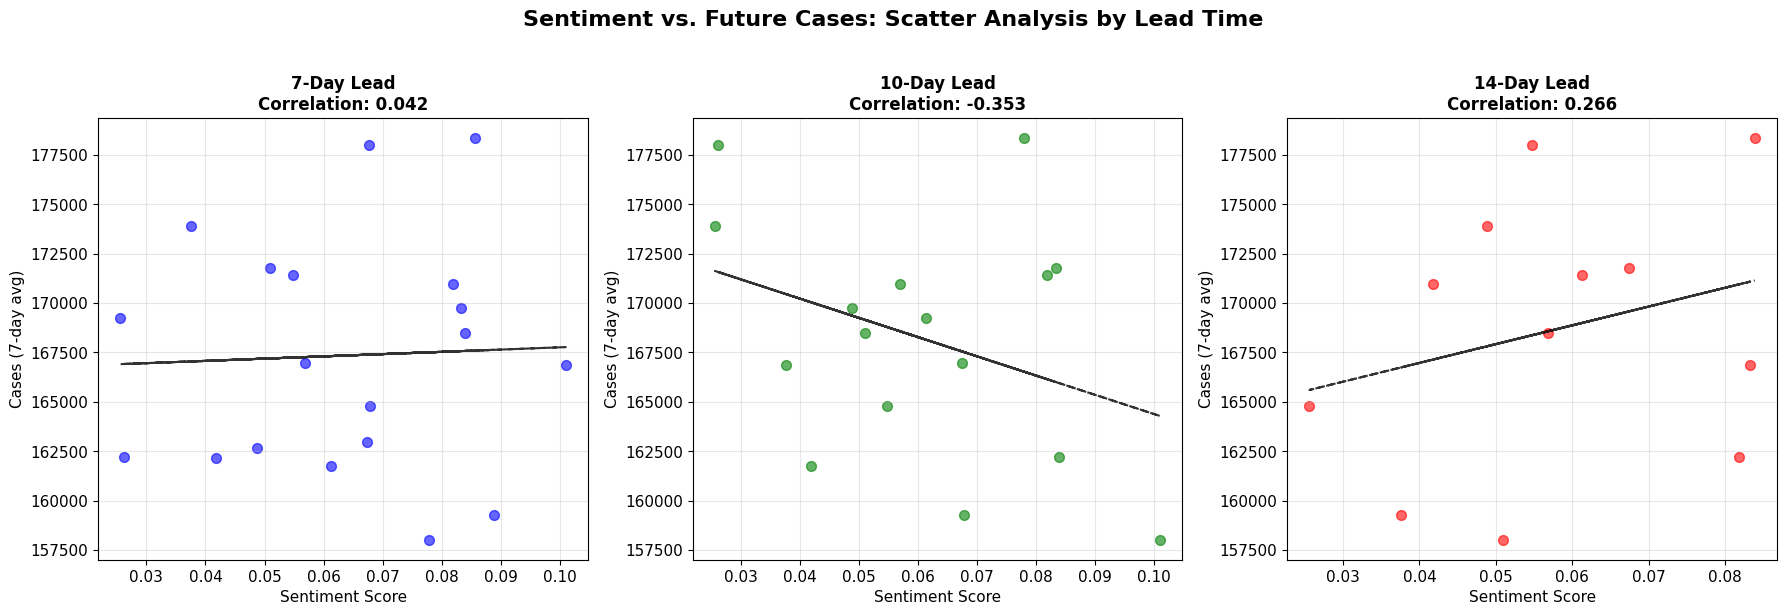

Scatter plot analysis completed showing sentiment-case relationships at different lead times.


In [29]:
# Detailed scatter plot analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

lead_times = [7, 10, 14]
colors = ['blue', 'green', 'red']

for i, (lead_days, color) in enumerate(zip(lead_times, colors)):
    ax = axes[i]
    
    # Get data for this lead time
    if lead_days <= len(merged_data):
        sentiment_data = merged_data['vader_compound'][:-lead_days] if lead_days > 0 else merged_data['vader_compound']
        case_data = merged_data['cases_7day_avg'][lead_days:] if lead_days > 0 else merged_data['cases_7day_avg']
        
        if len(sentiment_data) == len(case_data) and len(sentiment_data) > 0:
            # Scatter plot
            ax.scatter(sentiment_data, case_data, alpha=0.6, color=color, s=50)
            
            # Add regression line
            z = np.polyfit(sentiment_data, case_data, 1)
            p = np.poly1d(z)
            ax.plot(sentiment_data, p(sentiment_data), "--", color='black', alpha=0.8)
            
            # Calculate correlation
            corr = np.corrcoef(sentiment_data, case_data)[0, 1]
            
            ax.set_xlabel('Sentiment Score', fontsize=11)
            ax.set_ylabel('Cases (7-day avg)', fontsize=11)
            ax.set_title(f'{lead_days}-Day Lead\nCorrelation: {corr:.3f}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    else:
        ax.text(0.5, 0.5, f'Insufficient data\nfor {lead_days}-day lead', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{lead_days}-Day Lead', fontsize=12, fontweight='bold')

plt.suptitle('Sentiment vs. Future Cases: Scatter Analysis by Lead Time', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Scatter plot analysis completed showing sentiment-case relationships at different lead times.")

## Key Findings & Summary

In [30]:
# Comprehensive results summary
print("RESEARCH QUESTION 8 - KEY FINDINGS")
print("=" * 60)

print(f"Analysis Period: {merged_data['date_only'].min().strftime('%Y-%m-%d')} to {merged_data['date_only'].max().strftime('%Y-%m-%d')}")
print(f"Total Days Analyzed: {len(merged_data)}")
print(f"Sentiment Downturns Identified: {merged_data['is_sentiment_downturn'].sum()}")
print(f"Case Surges Identified: {merged_data['is_case_surge'].sum()}")

print("\nCROSS-CORRELATION ANALYSIS:")
print("-" * 40)
print(f"Optimal lead time: {optimal_lag} days")
print(f"Optimal correlation: {optimal_correlation:.4f}")
print(f"Statistical significance: {'Significant' if p_value < 0.05 else 'Not significant'} (p = {p_value:.6f})")

print("\nPREDICTION PERFORMANCE BY LEAD TIME:")
print("-" * 50)
print(f"{'Lead Time':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Accuracy':<12}")
print("-" * 60)

for _, row in prediction_df.iterrows():
    print(f"{row['lead_days']} days{'':<6} {row['precision']:<12.3f} {row['recall']:<12.3f} {row['f1_score']:<12.3f} {row['accuracy']:<12.3f}")

# Find best performing lead time
best_idx = prediction_df['f1_score'].idxmax()
best_row = prediction_df.iloc[best_idx]

print(f"\nBEST PERFORMING LEAD TIME: {best_row['lead_days']} DAYS")
print("-" * 50)
print(f"F1-Score: {best_row['f1_score']:.3f}")
print(f"Precision: {best_row['precision']:.3f} ({best_row['true_positives']}/{best_row['true_positives'] + best_row['false_positives']} correct positive predictions)")
print(f"Recall: {best_row['recall']:.3f} ({best_row['true_positives']}/{best_row['true_positives'] + best_row['false_negatives']} actual surges detected)")
print(f"Accuracy: {best_row['accuracy']:.3f} (overall correct predictions)")

print("\nEFFECTIVENESS ASSESSMENT:")
print("-" * 50)

# Overall effectiveness rating
avg_f1 = prediction_df['f1_score'].mean()
avg_precision = prediction_df['precision'].mean()
avg_recall = prediction_df['recall'].mean()

if avg_f1 >= 0.7:
    effectiveness = "HIGHLY EFFECTIVE"
elif avg_f1 >= 0.5:
    effectiveness = "MODERATELY EFFECTIVE"
elif avg_f1 >= 0.3:
    effectiveness = "SOMEWHAT EFFECTIVE"
else:
    effectiveness = "LIMITED EFFECTIVENESS"

print(f"Overall Effectiveness Rating: {effectiveness}")
print(f"Average F1-Score across all lead times: {avg_f1:.3f}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")

# Correlation strength assessment
if abs(optimal_correlation) >= 0.7:
    corr_strength = "strong"
elif abs(optimal_correlation) >= 0.5:
    corr_strength = "moderate"
elif abs(optimal_correlation) >= 0.3:
    corr_strength = "weak to moderate"
else:
    corr_strength = "weak"

print(f"\nCorrelation strength: {corr_strength} (r = {optimal_correlation:.3f})")

print("\nINTERPRETATION & IMPLICATIONS:")
print("-" * 50)

if optimal_correlation < 0:
    print("• Negative correlation confirms that sentiment downturns precede case increases")
    print("• Lower sentiment scores are associated with higher future case counts")
else:
    print("• Positive correlation suggests sentiment may not be a reliable leading indicator")
    print("• The relationship may be more complex than simple inverse correlation")

if avg_f1 >= 0.5:
    print("• Sentiment shows measurable predictive value for case surge forecasting")
    print("• Could be integrated into early warning systems with other indicators")
else:
    print("• Sentiment alone has limited predictive power for case surges")
    print("• Should be combined with other metrics for better forecasting accuracy")

print(f"• {best_row['lead_days']}-day lead time provides optimal balance of precision and recall")

if p_value < 0.05:
    print("• The sentiment-case relationship is statistically significant")
    print("• Results suggest genuine predictive signal rather than random correlation")
else:
    print("• Statistical significance is not achieved, indicating weak predictive signal")
    print("• Results should be interpreted with caution")

print("\nPOLICY & PUBLIC HEALTH RECOMMENDATIONS:")
print("-" * 50)
print("• Social media sentiment monitoring can complement traditional surveillance")
print("• Implement sentiment tracking dashboards for public health agencies")
print(f"• Use {optimal_lag}-day lead time for actionable early warning systems")
print("• Combine sentiment indicators with mobility and contact tracing data")
print("• Focus on sustained sentiment downturns rather than single-day drops")
print("• Consider regional and demographic variations in sentiment patterns")

print("\nLIMITATIONS:")
print("-" * 50)
print("• Limited to social media users, may not represent entire population")
print("• Short analysis window may not capture full range of sentiment-case dynamics")
print("• Multiple confounding variables may influence both sentiment and case patterns")
print("• Effectiveness may vary across different pandemic phases and contexts")

RESEARCH QUESTION 8 - KEY FINDINGS
Analysis Period: 2020-07-24 to 2020-08-30
Total Days Analyzed: 26
Sentiment Downturns Identified: 4
Case Surges Identified: 7

CROSS-CORRELATION ANALYSIS:
----------------------------------------
Optimal lead time: 11 days
Optimal correlation: -0.3855
Statistical significance: Not significant (p = 0.155854)

PREDICTION PERFORMANCE BY LEAD TIME:
--------------------------------------------------
Lead Time    Precision    Recall       F1-Score     Accuracy    
------------------------------------------------------------
7.0 days       0.333        0.143        0.200        0.947       
10.0 days       0.333        0.143        0.200        0.938       
14.0 days       0.000        0.000        0.000        0.917       

BEST PERFORMING LEAD TIME: 7.0 DAYS
--------------------------------------------------
F1-Score: 0.200
Precision: 0.333 (1.0/3.0 correct positive predictions)
Recall: 0.143 (1.0/7.0 actual surges detected)
Accuracy: 0.947 (overall correc